## Clustering  

Exploratory clustering of T2D and lipids data. The goal of clustering is to determine whether there is a certain subset of points that are similar to each other - whether these splits are made between, across or within the trait labels. Clustering is highly dependent on the parameters chosen for distance measure and the number of desired clusters. Moreover, clustering is not guaranteed to produce useful results, depending on the structure of the data and on the definition of what a 'useful' cluster is. 

In [18]:
import pandas as pd
import numpy as np
import boto3
import s3fs
import os
import sys
import warnings
import random
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances, accuracy_score, recall_score, precision_score, silhouette_score
from scipy import stats
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from Evaluator import Evaluator
from auth import access_key, secret_key

In [31]:
filepath = "s3://voightlab-data/multilabel/Weighted/"

In [32]:
X_train = pd.read_csv(filepath + "FeatureSelected/chi2/X_train.csv", index_col=0)
y_train = pd.read_csv(filepath + "FeatureSelected/chi2/y_train.csv", index_col=0)

X_train = X_train.reset_index()
y_train = y_train.reset_index()

X_train.head()

,index,E011-H3K4me1.gappedPeak,E100-H3K9me3.gappedPeak,E039-H3K9me3.gappedPeak,E077-H3K9me3.gappedPeak,E090-H3K9me3.gappedPeak,E012-H3K36me3.gappedPeak,E113-H3K9me3.gappedPeak,E009-H3K9me3.gappedPeak,E068-H3K9me3.gappedPeak,...,E002-H3K9me3.gappedPeak,E043-H3K9me3.gappedPeak,H1-hESC_ChIP-seq_H4K20me1_ENCFF001SVF.bed,E085-H3K9me3.gappedPeak,E034-H3K9me3.gappedPeak,E045-H3K9me3.gappedPeak,E129-H3K9me3.gappedPeak,E046-H3K9me3.gappedPeak,E089-H3K9me3.gappedPeak,E044-H3K9me3.gappedPeak
0,3761,0.159445,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.140336,0.000000,...,0.000000,0.000000,0.298983,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
1,2367,0.159445,0.000000,0.000000,0.000000,0.0,0.201615,0.000000,0.000000,0.000000,...,0.119396,0.000000,0.298983,0.127441,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
2,4085,0.159445,0.000000,0.000000,0.000000,0.0,0.201615,0.102936,0.140336,0.097012,...,0.000000,0.000000,0.298983,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
3,10218,0.159445,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.298983,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
4,7143,0.159445,0.078831,0.067947,0.094133,0.0,0.000000,0.102936,0.140336,0.097012,...,0.119396,0.097588,0.000000,0.127441,0.100616,0.0,0.071681,0.081607,0.06177,0.098339


In [36]:
X_test = pd.read_csv(filepath + "FeatureSelected/chi2/X_test.csv", index_col=0)
y_test = pd.read_csv(filepath + "FeatureSelected/chi2/y_test.csv", index_col=0)
y_test.head()

,is_BMI,is_CAD,is_T2D,is_lipids
7773,0.0,0.0,0.0,0.0
5206,0.0,0.0,0.0,0.0
8664,0.0,0.0,0.0,0.0
9151,0.0,0.0,0.0,1.0
2104,1.0,0.0,0.0,0.0


In [37]:
# Init class for plotting and model evaluation
ev = Evaluator()

In [38]:
# Some utility functions to help us compare clustering with a few different parameters
def concat_labels(df, labels):
    labeled_df = pd.concat([df, labels], axis=1)
    return labeled_df

def make_labels(df):
    cols = list(df.columns)
    labels = []
    
    for index, row in df.iterrows():
        possible_labels = []
        
        for col in cols:
            if row[col] == 1:
                possible_labels.append(col)
                
        if not possible_labels:
            labels.append(0)
        else:
            rand_label = random.choice(possible_labels)
            label = cols.index(rand_label) + 1
            labels.append(label)
    
    return labels

In [39]:
def cluster_compare(n_clusters, model, data, metric):
    results = []
    labels = []
    
    for n in n_clusters:
        model.n_clusters=n
        model.fit(data)
        predictions = pd.Series(model.labels_, name='label')
        unique, counts = np.unique(predictions, return_counts=True)
        
        if 'label' in data.columns:
            data['label'] = predictions
        else:
            data = concat_labels(data, predictions)
        
        cluster_metrics = []
        
        for index,val in enumerate(unique):
            avg_dist = pairwise_distances(data.loc[data['label'] == val], metric=metric, n_jobs=-1).mean()
            cluster_metrics.append(avg_dist)
        
        cluster_labels = [str(val) for val in unique] 
        labels.append(cluster_labels)
        results.append(cluster_metrics)
            
    titles = [(str(n) + " Clusters\n" ) for n in n_clusters]
    ev.plot_compare(results, labels, 'cluster number', 'avg  {} distance'.format(metric), titles, False)

In [40]:
bin_y_train = make_labels(y_train)
bin_y_test = make_labels(y_test)

In [41]:
print (pd.Series(bin_y_train).value_counts())

0    3169
2     854
5     422
4     368
3     218
1       1
dtype: int64


### Comparing similarity of classes
Intuitively we might think that certain traits would share important features. Here we compute and plot the average pairwise distance between all the points of two classes with each other. This allows us to tell which classes contain feature vectors more similar to each other. 

In [42]:
def pairwise_dist(trait1, trait2, metric='hamming'):
   
    # Concat the trait labels to each dataframe
    t1_df = pd.concat([X_train, y_train[trait1]], axis=1)
    t2_df = pd.concat([X_train, y_train[trait2]], axis=1)
    
    # Save only the positive instances for both
    t1_positives = t1_df[t1_df[trait1] == 1]
    t2_positives = t2_df[t2_df[trait2] == 1]
    
    distances = cdist(t1_positives, t2_positives, metric=metric)
    return distances.mean()
    

In [43]:
# Generate all possible pairings and save for plot
data = []
labels =[]
traits = y_train.columns[1:]

# Choose distance metric to compute pairwise distances on
metric = 'correlation'

for i, trait1 in enumerate(traits):
    for j, trait2 in enumerate(traits[i+1:]):
        labels.append("{}-{}".format(trait1, trait2))
        dist = pairwise_dist(trait1, trait2, metric=metric)
        data.append(dist)

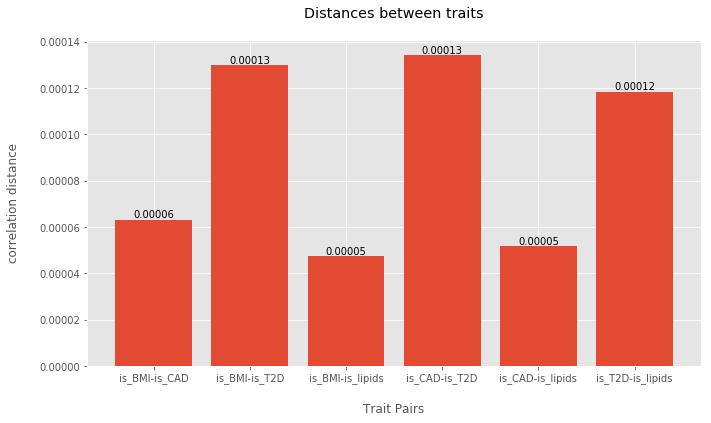

In [44]:
plt.figure(figsize=(11,6))
bars = plt.bar(labels, data)
plt.title("Distances between traits\n")
plt.ylabel("{} distance\n".format(metric))
plt.xlabel("\nTrait Pairs")

# Add counts above the two bar graphs
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, "{0:.5f}".format(height), ha='center', va='bottom')

plt.show()

### Agglomerative Clustering

A hierarchical clustering method with a bottom-up approach. Each observation starts in its own cluster and clusters are iteratively merged in a way to minimize some linkage criterion. 

In [13]:
agg_cluster = AgglomerativeClustering(n_clusters=5,
#                                       affinity='l1',
                                      linkage='ward')

In [14]:
agg_cluster.fit(X_train)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x7f0b6009f620>)

In [15]:
labels = agg_cluster.labels_
unique, counts = np.unique(labels, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  0 597]
 [  1 494]
 [  2 388]
 [  3 404]
 [  4 238]]


In [16]:
silhouette_score(X_test, bin_y_test, metric='hamming')

-0.00876838642162702

In [17]:
cluster_compare([3, 4, 5, 6], agg_cluster, X_train, 'hamming')

NameError: name 'plot_compare' is not defined